In [1]:
#!pip install --upgrade google-api-python-client
#!pip install --upgrade google-api-python-client
#!pip install progressbar 
#!pip install googletrans
#!pip install vaderSentiment

## 1) Libraries

In [135]:
import pandas as pd
from apiclient.discovery import build
from oauth2client.service_account import ServiceAccountCredentials
import asyncio
import progressbar
import time
import os.path

import seaborn as sb
import matplotlib.pyplot as plt

from google_trans_new import google_translator  
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import string
import re

## 2) Loading Dataset

In [78]:
df= pd.read_csv("vdoLinks.csv")
df

,youtubeId,movieId,title
0,K26_sDKnvMU,1,Toy Story (1995)
1,3LPANjHlPxo,2,Jumanji (1995)
2,rEnOoWs3FuA,3,Grumpier Old Men (1995)
3,j9xml1CxgXI,4,Waiting to Exhale (1995)
4,ltwvKLnj1B4,5,Father of the Bride Part II (1995)
...,...,...,...
25618,-oB6DN5dYWo,131252,Forklift Driver Klaus: The First Day on the Jo...
25619,DK7KQ-gEdl4,131256,"Feuer, Eis & Dosenbier (2002)"
25620,v29P-wchMZQ,131258,The Pirates (2014)
25621,dAz-nZ65jYU,131260,Rentun Ruusu (2001)


## 3) Initializing Google Youtube Api service

1) Service to fetch likes, dislikes, view count, duration, and comment count

In [79]:
def get_service(api_name, api_version, scopes, key_file_location):
    credentials = ServiceAccountCredentials.from_json_keyfile_name(
        key_file_location, scopes=scopes)
    
    # Build the service object.
    service = build(api_name, api_version, credentials=credentials)
    return service


In [80]:
CLIENT_SECRET_FILE = "youtube-analytics-secret.json"  # Google Cloud console; Service Account .json file
API_NAME = "youtube"
API_VERSION = "v3"

SCOPES = 'https://www.googleapis.com/auth/youtube'

youtube_service = get_service(API_NAME, API_VERSION, SCOPES, CLIENT_SECRET_FILE)

2) Service to fetch Youtube comments

In [81]:
DEVELOPER_KEY = "Google-Cloud-Console-YOUTUBE V3 API-KEY" 

youtube_comments = build(API_NAME,API_VERSION,developerKey=DEVELOPER_KEY)

In [82]:
part_string = 'contentDetails, statistics, snippet' #Snippet contains all important details of video

## 4) Initializing Dataframe to store extracted Youtube data

In [83]:
df_extracted = pd.DataFrame(columns=['YoutubeId',#'MovieId',
                                     'Title', 'Description', 'comments',
                            'View_Count','like_Count','Dislike_Count','Comment_Count',
                            'Duration','Fav_Count'])
df_error_ids = pd.DataFrame(columns=['youtubeId','movieId','title','error'])

## 5) Extracting Youtube data

In [84]:
async def fetchingData(video_ids, df_, youtube, prev, x):
    video_response = youtube_service.videos().list(part=part_string, id=video_ids.tolist()).execute()
    widgets = ['Loading ===> ',str(prev),' to ',str(x),' data : ', progressbar.AnimatedMarker()]
    bar = progressbar.ProgressBar(widgets=widgets).start()
    try:
        # retrieve youtube video results
        item_count = 0

        for i in video_response['items']:
            # iterate video response
            comments_dict = {}
            replies = []
            comments = []

            try:
                video_comments = youtube.commentThreads().list(part='snippet,replies', videoId=i['id']).execute()

                comment_count = 1
                while video_comments:

                    for item in video_comments['items']:
                        if comment_count > 100:
                            break

                        # Extracting comments
                        comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
                        comments.append(comment)

                        replycount = item['snippet']['totalReplyCount']
                        if replycount > 0:
                            for reply in item['replies']['comments']:
                                reply = reply['snippet']['textDisplay']
                                replies.append(reply)

                        comment_count += 1
                        # Again repeat
                    if 'nextPageToken' in video_comments:
                        video_comments = youtube.commentThreads().list(part='snippet,replies', videoId=i['id']).execute()
                    else:
                        break
                    if comment_count > 100:
                        break

            except Exception as e:
                replies = []
                comments = []

            comments_dict['comments'] = comments
            comments_dict['replies'] = replies

            likeCount = 0
            viewCount = 0
            dislikeCount = 0
            commentCount = 0
            duration = 0
            favoriteCount = 0

            if 'likeCount' in i['statistics']:
                likeCount = i['statistics']['likeCount']
            if 'viewCount' in i['statistics']:
                viewCount = i['statistics']['viewCount']
            if 'dislikeCount' in i['statistics']:
                dislikeCount = i['statistics']['dislikeCount']
            if 'commentCount' in i['statistics']:
                commentCount = i['statistics']['commentCount']
            if 'duration' in i['contentDetails']:
                duration = i['contentDetails']['duration']
            if 'favoriteCount' in i['statistics']:
                favoriteCount = i['statistics']['favoriteCount']

            df_extracted.loc[len(df_extracted.index)] = [i['id'],#df_['youtubeId'][item_count], df_['movieId'][item_count],
                                                         i['snippet']['title'],i['snippet']['description'], 
                                                         comments_dict, viewCount, likeCount,dislikeCount, 
                                                         commentCount, duration, favoriteCount]
            item_count += 1
            bar.update(item_count)
    except Exception as e:
        print(e)

In [85]:
async def getYoutubeData(df,youtube):
    prev=0
    tasks=[]
    for x in range(50, len(df.index)+50, 50):
        tasks.append(fetchingData(df['youtubeId'][prev:x], df[prev:x], youtube_comments, prev, x))
        prev=x+1
        
    tasks.reverse()
    await asyncio.wait(tasks)
    if df_extracted.empty:
        print('No more record(s) to fetch...')
        return
    if os.path.isfile('Youtube_Data_Extracted.csv'):
        #File Exist
        df_extracted.to_csv('Youtube_Data_Extracted.csv', mode='a')#, header=False)
    else:
        #FIle Not Exist
        df_extracted.to_csv('Youtube_Data_Extracted.csv')
        


In [86]:
def removeExtractedData():
    df_temp = pd.read_csv("vdoLinks.csv",index_col=0)
    df_extracted = pd.read_csv("Youtube_Data_Extracted.csv",encoding='ISO-8859-1')
    list_ = df_extracted['YoutubeId'].tolist()
    for i in list_:
        try:
            df_temp = df_temp.drop(i, axis=0)#, inplace=True)
        except Exception as e:
            print(e)
    return df_temp

In [1]:
#Filtering already extracted youtube videos
if os.path.isfile('Youtube_Data_Extracted.csv'):
    df_filtered = removeExtractedData()
    df_filtered = df_filtered.reset_index()
    result = await getYoutubeData(df_filtered, youtube_comments)
else:
    result = await getYoutubeData(df, youtube_comments)
result

In [88]:
df_extracted

,YoutubeId,Title,Description,comments,View_Count,like_Count,Dislike_Count,Comment_Count,Duration,Fav_Count
0,-txGiUtVAjM,Born to Dance - Trailer,Multiple Oscar and Golden Globe-winner James S...,{'comments': ['This was Cole Porter&#39;s firs...,15543,0,0,3,PT4M36S,0
1,-jqYxuLOyyo,L'armata Brancaleone,L'armata Brancaleone (known in English-speakin...,"{'comments': ['Secondo me , bisognerebbe resus...",60066,76,2,15,PT1M26S,0
2,-o1UK8Ovb_A,Luminarias,Welcome to Luminarias—where hot spicy dish get...,{'comments': ['I love this movie 💃🏿mi gusts!']...,1733,6,1,1,PT1M45S,0
3,-JAMmi5g3_s,Jerzy Kawalerowicz NIGHT TRAIN (Pociag) montage,Kawalerowicz's celebrated film is considered o...,"{'comments': ['Il film, rarissimo da vedere, è...",24323,145,1,7,PT1M1S,0
4,-btN0VAVFlU,Crack-Up,"Crackup starring Pat O'brien, Claire Trevor an...",{'comments': ['Pat was my cousin. Met him a fe...,2958,16,1,4,PT2M14S,0
...,...,...,...,...,...,...,...,...,...,...
192,-y5YqwWK9ts,Uro - Trailer,Turning his back on a delinquent past and join...,{'comments': ['Does it exist in french or engl...,179004,100,13,13,PT1M55S,0
193,-h8wWFqwmcA,Bad Company,Academy Award(R)-winner Anthony Hopkins stars ...,"{'comments': [], 'replies': []}",235701,0,0,0,PT2M19S,0
194,-ZDvhYsm2as,Harry And Walter Go To New York,,{'comments': ['Been my favorite movie comedy s...,11590,28,2,4,PT2M18S,0
195,-vnBvDPXZk0,Stone of Destiny trailer,Director: Charles Martin Smith\r\nWriter: Char...,"{'comments': ['ONCE UPON A TIME', 'Is this fil...",222219,195,21,95,PT1M31S,0


## 6) Displaying extracted data

In [185]:
df_extracted_2 = pd.read_csv('Youtube_Data_Extracted.csv',encoding='ISO-8859-1')
df_extracted_2

,Unnamed: 0,YoutubeId,Title,Description,comments,View_Count,like_Count,Dislike_Count,Comment_Count,Duration,Fav_Count
0,0,PFCnp70cyp4,How to Pickup Using the Theory of Relativity!,"From the bopic of Stephen Hawking, 'Hawking' (...","{'comments': ['Doesn&#39;t work, I tried :/', ...",38078,205,2,22,PT2M1S,0
1,1,mU5Dhcjmkaw,Finding Joy - Theatrical Trailer (2013) Movie ...,Finding Joy - Theatrical Trailer (2013) Movie ...,"{'comments': [], 'replies': []}",903,3,1,0,PT2M8S,0
2,2,gOP3Uicg04U,'Now Is Good' Trailer HD,http://www.hollywood.com\n\n'Now Is Good' Trai...,"{'comments': ['i know im little too lat ehere,...",218744,899,32,114,PT1M56S,0
3,3,iXjEqm39oMw,The Adonis Factor (Trailer),DVD Release: October 2010\n\nBuy Now:http://sh...,"{'comments': ['Sadly, unless you have six-pack...",27136,28,11,5,PT1M29S,0
4,4,M1m020Mp39E,Call Me Kuchu Documentary Trailer,"CALL ME KUCHU TRAILER \n\nIn Uganda, a new bil...",{'comments': ['i&#39;m glad you are able to sh...,47973,182,11,14,PT4M38S,0
...,...,...,...,...,...,...,...,...,...,...,...
19701,192,#NAME?,Uro - Trailer,Turning his back on a delinquent past and join...,{'comments': ['Does it exist in french or engl...,179004,100,13,13,PT1M55S,0
19702,193,#NAME?,Bad Company,Academy Award(R)-winner Anthony Hopkins stars ...,"{'comments': [], 'replies': []}",235701,0,0,0,PT2M19S,0
19703,194,#NAME?,Harry And Walter Go To New York,NaN,{'comments': ['Been my favorite movie comedy s...,11590,28,2,4,PT2M18S,0
19704,195,#NAME?,Stone of Destiny trailer,Director: Charles Martin Smith\nWriter: Charle...,"{'comments': ['ONCE UPON A TIME', 'Is this fil...",222219,195,21,95,PT1M31S,0


## 7) Preprocessing & EDA

In [186]:
df_extracted_2.shape

(19706, 11)

In [187]:
df_extracted_2.drop('Unnamed: 0', axis=1, inplace=True)

#### 1) Removing Duplicates

In [188]:
df_extracted_2.drop_duplicates(subset ="YoutubeId",
                     keep = False, inplace = True)
df_extracted_2.shape

(18896, 10)

In [140]:
df_extracted_2

,YoutubeId,Title,Description,comments,View_Count,like_Count,Dislike_Count,Comment_Count,Duration,Fav_Count
0,PFCnp70cyp4,How to Pickup Using the Theory of Relativity!,"From the bopic of Stephen Hawking, 'Hawking' (...","{'comments': ['Doesn&#39;t work, I tried :/', ...",38078,205,2,22,PT2M1S,0
1,mU5Dhcjmkaw,Finding Joy - Theatrical Trailer (2013) Movie ...,Finding Joy - Theatrical Trailer (2013) Movie ...,"{'comments': [], 'replies': []}",903,3,1,0,PT2M8S,0
2,gOP3Uicg04U,'Now Is Good' Trailer HD,http://www.hollywood.com\n\n'Now Is Good' Trai...,"{'comments': ['i know im little too lat ehere,...",218744,899,32,114,PT1M56S,0
3,iXjEqm39oMw,The Adonis Factor (Trailer),DVD Release: October 2010\n\nBuy Now:http://sh...,"{'comments': ['Sadly, unless you have six-pack...",27136,28,11,5,PT1M29S,0
4,M1m020Mp39E,Call Me Kuchu Documentary Trailer,"CALL ME KUCHU TRAILER \n\nIn Uganda, a new bil...",{'comments': ['i&#39;m glad you are able to sh...,47973,182,11,14,PT4M38S,0
...,...,...,...,...,...,...,...,...,...,...
19099,WJAl87qTf40,Oranges (2004),Two boys are talking after a bicycle accident....,"{'comments': ['At the end, I don&#39;t think t...",67959,603,36,46,PT11M23S,0
19101,te4N3sOlaXs,Such a Long Journey,"Trailer for Such a Long Journey, part of the R...",{'comments': ['can somebody please tell me whe...,21489,51,3,13,PT2M,0
19107,YCGbTeb4USk,The Devil's Chair official trailer,"With a pocketful of drugs, Nick West (Andrew H...","{'comments': ['Dude, I bought this movie at a ...",377379,352,69,159,PT1M59S,0
19108,LvyglNQguFk,All the President's Men trailer #1,http://peelslowlynsee.wordpress.com/2010/03/23...,"{'comments': [], 'replies': []}",25568,23,1,0,PT1M48S,0


In [141]:
df_extracted_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18896 entries, 0 to 19112
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   YoutubeId      18896 non-null  object
 1   Title          18896 non-null  object
 2   Description    18383 non-null  object
 3   comments       18896 non-null  object
 4   View_Count     18896 non-null  int64 
 5   like_Count     18896 non-null  int64 
 6   Dislike_Count  18896 non-null  int64 
 7   Comment_Count  18896 non-null  int64 
 8   Duration       18896 non-null  object
 9   Fav_Count      18896 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 1.6+ MB


#### 2)Converting Object data type to Integer

In [142]:
df_extracted_2[["View_Count", "like_Count","Dislike_Count","Comment_Count","Fav_Count"]] = df_extracted_2[["View_Count", "like_Count","Dislike_Count","Comment_Count","Fav_Count"]].astype('int64')

In [145]:
df_extracted_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18896 entries, 0 to 19112
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   YoutubeId      18896 non-null  object
 1   Title          18896 non-null  object
 2   Description    18383 non-null  object
 3   comments       18896 non-null  object
 4   View_Count     18896 non-null  int64 
 5   like_Count     18896 non-null  int64 
 6   Dislike_Count  18896 non-null  int64 
 7   Comment_Count  18896 non-null  int64 
 8   Duration       18896 non-null  object
 9   Fav_Count      18896 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 1.6+ MB


## 8) Results

### 1) A list of the top-10 vides based on the total views

In [146]:
top_10_views = df_extracted_2.sort_values(by=['View_Count'], ascending=False).head(10)

In [147]:
labels = top_10_views['Title'].values.tolist()
print('Top 10 viewed videos:', labels)

Top 10 viewed videos: ['John Legend - All of Me (Official Video)', 'Fresh Guacamole by PES | Oscar Nominated Short', 'Unfaithful (2002) - The Other Woman Scene (1/3) | Movieclips', 'Britney Spears - Ooh La La (From The Smurfs 2)', 'Beastie Boys - Sabotage', 'ILO ILO ??????????????? Official Trailer', 'Growth Trailer', 'Transformers 3 Dark of the Moon Teaser Trailer - Official (HD)', "Disney's Frozen Fever Trailer", 'Don {HD} - Amitabh Bachchan - Zeenat Aman - Superhit Old Hindi Movie - (With Eng Subtitles)']


<ipython-input-148-235354abb158>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=top_10_views['YoutubeId'],rotation=90, fontsize=16)


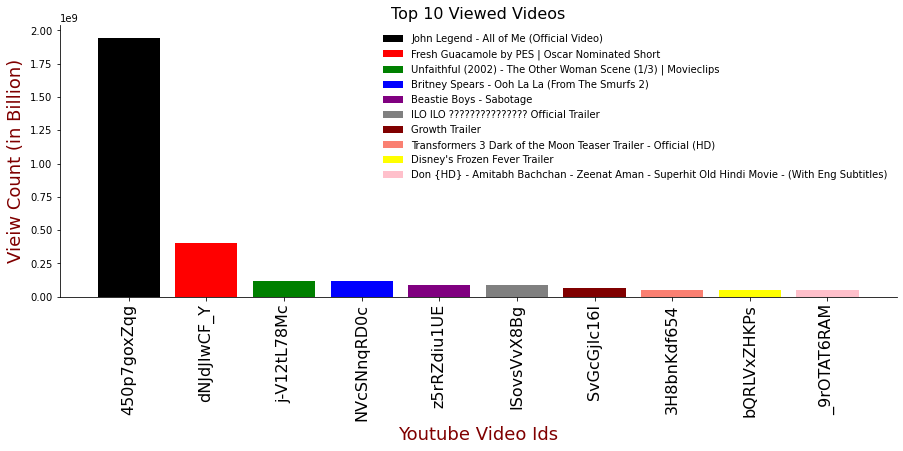

In [148]:
my_colors = ['black', 'red', 'green', 'blue', 'purple', 'grey', 'maroon', 'salmon', 'yellow','pink']

f = plt.figure(figsize =(15, 5) )


ax = plt.subplot(111) #specify a subplot

count = 0
for index, row in top_10_views.iterrows():
    ax.bar(row['YoutubeId'], row['View_Count'], color =my_colors[count], label = labels[count])
    count+=1
    
ax=plt.gca()

ax.set_xticklabels(labels=top_10_views['YoutubeId'],rotation=90, fontsize=16)

ax.set_xlabel("Youtube Video Ids", fontsize=18, labelpad=5, color='maroon')
ax.set_ylabel("Vieiw Count (in Billion)", fontsize=18, labelpad=5, color='maroon')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.title("Top 10 Viewed Videos", fontsize=16)

plt.legend(labels,loc='best', frameon=False)#, bbox_to_anchor=(0.5, -0.5))
plt.show()

### 2) A list of the bottom-10 videos based on the total views

In [149]:
least_10_views = df_extracted_2.sort_values(by=['View_Count'], ascending=False).tail(10)

In [150]:
labels = least_10_views['Title'].values.tolist()
print('Bottom 10 viewed videos:', labels)

Bottom 10 viewed videos: ['Spring Fever', 'Black Fury', 'Okie Noodling', 'Ballad of Cable Hogue - Trailer', "Who's the Caboose", 'The Ballad Of Nessie', 'Behold A Pale Horse', 'The End Of The Affair (1955)', 'Houseguest', 'Born Reckless']


In [151]:
display(least_10_views)

,YoutubeId,Title,Description,comments,View_Count,like_Count,Dislike_Count,Comment_Count,Duration,Fav_Count
3320,ZRFoINOGzF0,Spring Fever,Another of William Haines' sports-oriented veh...,"{'comments': [], 'replies': []}",0,4,1,0,PT1H18M17S,0
4281,4yl9WtMypkg,Black Fury,"Based on real-life events, Black Fury brings v...","{'comments': ['Paul Muni, who along with Fredr...",0,6,1,1,PT1H33M56S,0
9075,EaWaBj6bqmA,Okie Noodling,Okie Noodling profiles the culture and sport o...,"{'comments': [], 'replies': []}",0,9,1,0,PT45M9S,0
5718,_4WgxKTJ09E,Ballad of Cable Hogue - Trailer,"Sam Peckinpah's light-hearted, rambunctious od...",{'comments': ['???????????????????????????????...,0,169,10,6,PT2M57S,0
8798,TuuqBBVkVB8,Who's the Caboose,"Sarah Silverman (The Sarah Silverman Program),...","{'comments': [], 'replies': []}",0,3,1,0,PT1H33M9S,0
18192,eyhE8H78NOU,The Ballad Of Nessie,"""The Ballad of Nessie"" is a whimsical and colo...","{'comments': [], 'replies': []}",0,0,0,0,PT5M32S,0
4927,gf7JRO9Ha1o,Behold A Pale Horse,Manuel has been on the run for 15 yearsand now...,"{'comments': ['Good film and good acting'], 'r...",0,22,4,1,PT2H1M8S,0
3382,IzS2e9m5848,The End Of The Affair (1955),From the novel by Graham Greene comes this sto...,{'comments': ['Deborah Kerr good actress but V...,0,17,5,6,PT1H45M47S,0
1708,irjJknY_r0Q,Houseguest,Hollywood's leading funnyman Sinbad drops in f...,"{'comments': [], 'replies': []}",0,251,32,0,PT1H44M17S,0
13276,ksHPfmx6y-4,Born Reckless,After a man (Edmund Lowe) convicted of theft i...,"{'comments': [], 'replies': []}",0,1,0,0,PT1H16M40S,0


<ipython-input-152-e83fd5d05412>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=least_10_views['YoutubeId'],rotation=90, fontsize=16)


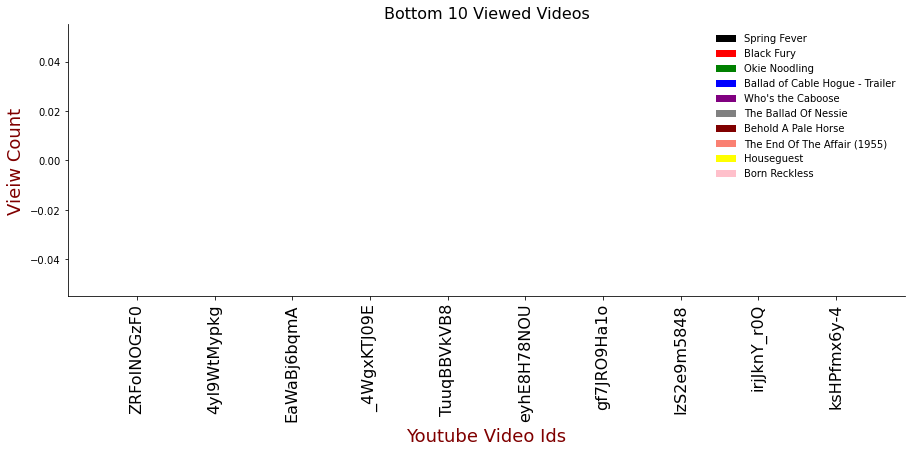

In [152]:
my_colors = ['black', 'red', 'green', 'blue', 'purple', 'grey', 'maroon', 'salmon', 'yellow','pink']
labels = least_10_views['Title'].values.tolist()

f = plt.figure(figsize =(15, 5) )


ax = plt.subplot(111) #specify a subplot

count = 0
for index, row in least_10_views.iterrows():
    ax.bar(row['YoutubeId'], row['View_Count'], color =my_colors[count], label = labels[count])
    count+=1
    
ax=plt.gca()

ax.set_xticklabels(labels=least_10_views['YoutubeId'],rotation=90, fontsize=16)

ax.set_xlabel("Youtube Video Ids", fontsize=18, labelpad=5, color='maroon')
ax.set_ylabel("Vieiw Count", fontsize=18, labelpad=5, color='maroon')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.title("Bottom 10 Viewed Videos", fontsize=16)

plt.legend(labels,loc='best', frameon=False)#, bbox_to_anchor=(0.5, -0.5))
plt.show()

### 3) The most liked video

In [153]:
top_liked_videos = df_extracted_2.sort_values(by=['like_Count'], ascending=False).head(10)

#### Title of top 10 liked videos

In [154]:
labels = top_liked_videos['Title'].values.tolist()
print('Top 10 liked videos:',labels)

Top 10 liked videos: ['John Legend - All of Me (Official Video)', 'Fresh Guacamole by PES | Oscar Nominated Short', 'Britney Spears - Ooh La La (From The Smurfs 2)', 'The Fault In Our Stars | Official Trailer [HD] | 20th Century FOX', 'Beastie Boys - Sabotage', 'Kiwi!', 'The Horribly Slow Murderer with the Extremely Inefficient Weapon by Richard Gale', 'POWER/RANGERS UNAUTHORIZED  [BOOTLEG UNIVERSE]', 'Too Many Cooks | Adult Swim', 'THE PUNISHER: DIRTY LAUNDRY [BOOTLEG UNIVERSE]']


<ipython-input-155-2adf4ec7c8fb>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=top_liked_videos['YoutubeId'],rotation=90, fontsize=16)


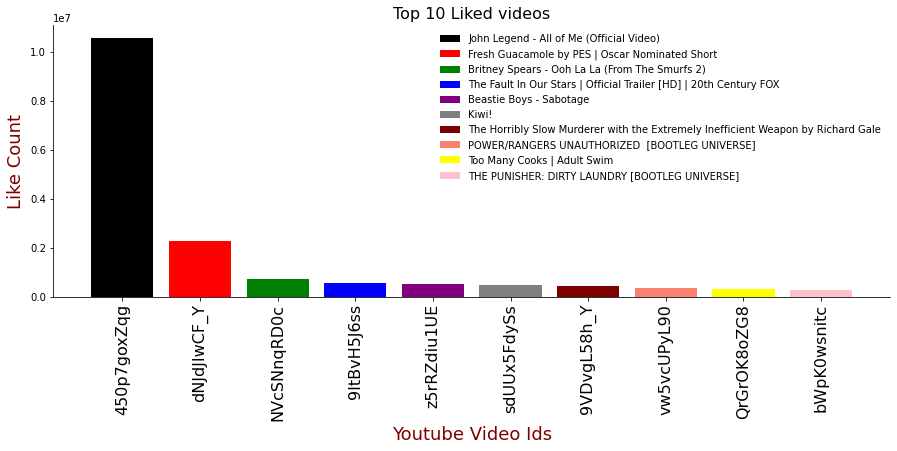

In [155]:
my_colors = ['black', 'red', 'green', 'blue', 'purple', 'grey', 'maroon', 'salmon', 'yellow','pink']

f = plt.figure(figsize =(15, 5) )


ax = plt.subplot(111) #specify a subplot

count = 0
for index, row in top_liked_videos.iterrows():
    ax.bar(row['YoutubeId'], row['like_Count'], color =my_colors[count], label = labels[count])
    count+=1
    
ax=plt.gca()

ax.set_xticklabels(labels=top_liked_videos['YoutubeId'],rotation=90, fontsize=16)

ax.set_xlabel("Youtube Video Ids", fontsize=18, labelpad=5, color='maroon')
ax.set_ylabel("Like Count", fontsize=18, labelpad=5, color='maroon')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.title("Top 10 Liked videos", fontsize=16)

plt.legend(labels,loc='best', frameon=False)#, bbox_to_anchor=(0.5, -0.5))

plt.show()

### 4) The least liked video

In [156]:
least_10_liked = df_extracted_2.sort_values(by=['like_Count'], ascending=False).tail(5)

In [157]:
display(least_10_liked)

,YoutubeId,Title,Description,comments,View_Count,like_Count,Dislike_Count,Comment_Count,Duration,Fav_Count
1554,24XiqMIC6q8,48 Hrs. - Trailer,Nick Nolte and Eddie Murphy make one of the mo...,"{'comments': [], 'replies': []}",477932,0,0,0,PT3M7S,0
16787,JzYllBpl-9I,Happiness - Trailer,"From Todd Solondz, director of the acclaimed W...","{'comments': [], 'replies': []}",613333,0,0,0,PT2M4S,0
17728,oqWMDmFx4lo,Virginia City - Trailer,After escaping from a Confederate prison durin...,"{'comments': [], 'replies': []}",17859,0,0,0,PT1M58S,0
12117,suaDCyBbXXg,A Piece of the Action - Trailer,Sidney Poitier directed and stars in this come...,"{'comments': [], 'replies': []}",100903,0,0,0,PT2M5S,0
10676,9daIbBlaEIA,Unhook the Stars - Trailer,Gena Rowlands and Academy Award winner Marisa ...,"{'comments': [], 'replies': []}",14986,0,0,0,PT2M25S,0


#### Title of Least 5 liked videos

In [158]:
labels = least_10_liked['Title'].values.tolist()
print('Least 5 liked Video:',labels)

Least 5 liked Video: ['48 Hrs. - Trailer', 'Happiness - Trailer', 'Virginia City - Trailer', 'A Piece of the Action - Trailer', 'Unhook the Stars - Trailer']


<ipython-input-159-47581953e8aa>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=least_10_liked['YoutubeId'],rotation=90, fontsize=16)


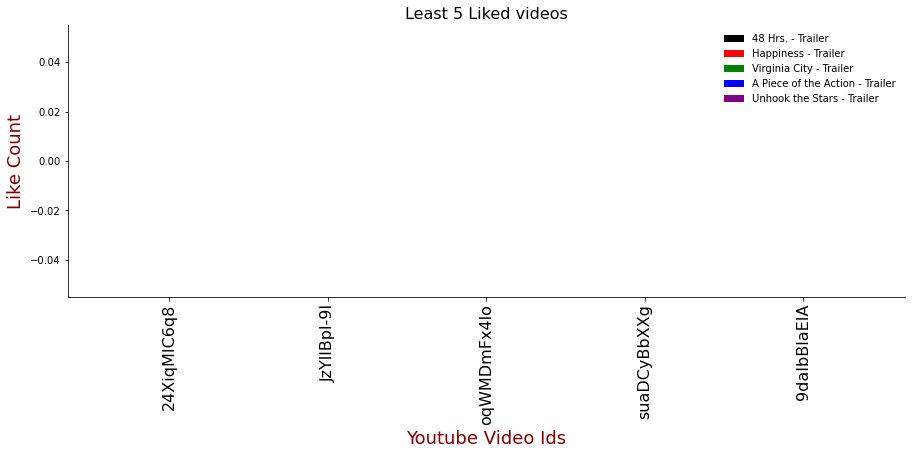

In [159]:
my_colors = ['black', 'red', 'green', 'blue', 'purple', 'grey', 'maroon', 'salmon', 'yellow','pink']

f = plt.figure(figsize =(15, 5) )


ax = plt.subplot(111) #specify a subplot

count = 0
for index, row in least_10_liked.iterrows():
    ax.bar(row['YoutubeId'], row['like_Count'], color =my_colors[count], label = labels[count])
    count+=1
    
ax=plt.gca()

ax.set_xticklabels(labels=least_10_liked['YoutubeId'],rotation=90, fontsize=16)

ax.set_xlabel("Youtube Video Ids", fontsize=18, labelpad=5, color='maroon')
ax.set_ylabel("Like Count", fontsize=18, labelpad=5, color='maroon')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.title("Least 5 Liked videos", fontsize=16)

plt.legend(labels,loc='best', frameon=False)#, bbox_to_anchor=(0.5, -0.5))

plt.show()

### 5) The video with the highest duration

In [160]:
def hoursToMins(x):
    hrs = 0
    mins = 0
    sec = 0
    #Here, x will be PT1M59S
    if 'PT' in x:
        #print(x)
        x = x.split('PT')
        
        if 'H' in x[1]:
            x = x[1].split('H')
            hrs = int(x[0])
            if 'M' in x[1]: #PT2M1S
                x = x[1].split('M') #PT - 1M59S
                mins = int(x[0])
            if 'S' in x[1]:
                x = x[1].split('S') #PT - 1M59S
                sec = int(x[0])
            
        elif 'M' in x[1]: #PT2M1S
            x = x[1].split('M') #PT - 1M59S
            mins = int(x[0])
            if 'S' in x[1]:
                x = x[1].split('S') #PT - 1M59S
                sec = int(x[0])
        elif 'S' in x[1]:
            x = x[1].split('S') #PT - 1M59S
            sec = int(x[0])
            
    total_secs = hrs*60*60 + mins*60 + sec
    #print(hrs, hrs*60*60, mins, mins*60, sec)
    return total_secs
    
#hoursToMins('PT1H20S')

In [161]:
df_extracted_2['Duration(in secs)'] = df_extracted_2['Duration'].apply(lambda x: hoursToMins(x))

In [162]:
top_duration_videos = df_extracted_2.sort_values(by=['Duration(in secs)'], ascending=False).head(5)

#### Title of the videos that has the highest duration

In [163]:
labels = top_duration_videos['Title'].values.tolist()
print('Top 5 highest duration Video:',labels)

Top 5 highest duration Video: ['Trailer for "Getting to Know You"', 'The Century of the Self (Full Documentary)', 'The best of youth (trailer)', 'Peter Brook - Mahabharata 1', 'Kevin Smith: Too Fat for 40']


### 6) Apply sentiment analysis on the downloaded comments for each of the videos. For sentiment analysis, you can use VADER or any other tool of your choice. Your program should list the sentiments score for each of the movies

In [164]:
translator = google_translator()
sid_analyzer = SentimentIntensityAnalyzer()

In [165]:
df_extracted_2.describe()

,View_Count,like_Count,Dislike_Count,Comment_Count,Fav_Count,Duration(in secs)
count,1.889600e+04,1.889600e+04,18896.000000,18896.000000,18896.0,18896.000000
mean,7.037882e+05,2.409830e+03,152.401461,225.379763,0.0,414.329382
std,1.468251e+07,7.972435e+04,3229.688150,2233.122176,0.0,1245.247440
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000
25%,1.948925e+04,3.400000e+01,2.000000,3.000000,0.0,100.000000
50%,7.372650e+04,1.330000e+02,8.000000,15.000000,0.0,130.000000
75%,2.932128e+05,5.342500e+02,34.000000,70.000000,0.0,160.000000
max,1.942935e+09,1.057922e+07,320442.000000,230513.000000,0.0,46164.000000


In [166]:
df_extracted_2['Comment_Count'].sum()

4258776

In [167]:
dictionaryObject = df_extracted_2['comments'].to_dict()

In [168]:
count = 0
list = []
for i in dictionaryObject:
    #count+=1
    #print(i)
    #print(dictionaryObject[i])
    obj = dictionaryObject[i].strip()
    
    if ", 'replies':" in obj:#dictionaryObject[i]:
        obj = obj.split(", 'replies':")#dictionaryObject[i].split(", 'replies':")
        obj = obj[0]+'}'
        
    try:
        dic = eval(obj)#dictionaryObject[i])
        #print(dic['comments'])
    except:
        try:
            if obj[-2:] != ']}':#dictionaryObject[i][-2:] != ']}':
                if obj[-1] == "'" :
                    obj = obj+"]}"
                elif obj[-1] == ",":
                    if obj[-2] == "'":
                        obj = obj+"'']}"
                    else:
                        obj = obj+"']}"
                else:
                    obj = obj+"']}"
            dic = eval(obj)#dictionaryObject[i])
        except:
            obj = "{'comments': ['']}"
            dic = eval(obj)#dictionaryObject[i])
            count+=1
    
    list.append("".join(dic['comments']))

In [169]:
print('Total Videos:', len(df_extracted_2['comments']))
print('Total error count while parsing Comments of Videos:',count)

Total Videos: 18896
Total error count while parsing Comments of Videos: 4


In [170]:
print('Inbuilt Punctuations:',string.punctuation)
custom_punctuation = '"#$%&\'()*+,-./:;<=>@[\\]^_`{|}~'
print('Custom Punctuations:',custom_punctuation)

Inbuilt Punctuations: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
Custom Punctuations: "#$%&'()*+,-./:;<=>@[\]^_`{|}~


In [171]:
def comment_Cleaning(list, custom_punctuation):
    #translated_txt =[translator.translate(x,lang_tgt='en') for x in list]
    
    # Lowering text
    list_lower = [x.lower() for x in list]
    
    #Remvoing punctuations
    puntuation_filtered_txt = [txt.translate(str.maketrans(custom_punctuation, ' '*len(custom_punctuation))) for txt in list_lower]
    
    #Removing extra spaces
    pattern_1 = "\s+"
    cleaned_txt=[re.sub(pattern_1," ",x) for x in puntuation_filtered_txt]
    
    #Handlling unnecessary letter repetition
    pattern_2=re.compile(r"(.)\1{2,}")
    cleaned_txt=[pattern_2.sub(r"\1\1",x) for x in cleaned_txt]
    
    return cleaned_txt   

In [172]:
cleaned_comments = comment_Cleaning(list, custom_punctuation)

In [173]:
def sentiment_scores(sentence):
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    score = round(sentiment_dict['compound'], 2)
    return score

In [174]:
def sentiments(score):
    if score >= 0.05 :
        return 'Positive'#f'Positive: {score}'
 
    elif score <= - 0.05 :
        return 'Negative'#f'Negative: {score}'
 
    else :
        return 'Neutral'#f'Neutral: {score}'

In [175]:
sentiment = [sentiment_scores(comments) for comments in cleaned_comments]

In [176]:
print('Total list of comments:',len(list))
print('Total list of cleaned comments:',len(cleaned_comments))
print('Total list of comments sentiment:',len(sentiment))
#print('Total list of comments sentiment score:',len(score))

Total list of comments: 18896
Total list of cleaned comments: 18896
Total list of comments sentiment: 18896


In [177]:
df_extracted_2['Sentiment Score'] = sentiment
df_extracted_2['Sentiment'] = df_extracted_2['Sentiment Score'].apply(lambda x: sentiments(x))

In [178]:
df_extracted_2.head()

,YoutubeId,Title,Description,comments,View_Count,like_Count,Dislike_Count,Comment_Count,Duration,Fav_Count,Duration(in secs),Sentiment Score,Sentiment
0,PFCnp70cyp4,How to Pickup Using the Theory of Relativity!,"From the bopic of Stephen Hawking, 'Hawking' (...","{'comments': ['Doesn&#39;t work, I tried :/', ...",38078,205,2,22,PT2M1S,0,121,1.00,Positive
1,mU5Dhcjmkaw,Finding Joy - Theatrical Trailer (2013) Movie ...,Finding Joy - Theatrical Trailer (2013) Movie ...,"{'comments': [], 'replies': []}",903,3,1,0,PT2M8S,0,128,0.00,Neutral
2,gOP3Uicg04U,'Now Is Good' Trailer HD,http://www.hollywood.com\n\n'Now Is Good' Trai...,"{'comments': ['i know im little too lat ehere,...",218744,899,32,114,PT1M56S,0,116,1.00,Positive
3,iXjEqm39oMw,The Adonis Factor (Trailer),DVD Release: October 2010\n\nBuy Now:http://sh...,"{'comments': ['Sadly, unless you have six-pack...",27136,28,11,5,PT1M29S,0,89,-0.71,Negative
4,M1m020Mp39E,Call Me Kuchu Documentary Trailer,"CALL ME KUCHU TRAILER \n\nIn Uganda, a new bil...",{'comments': ['i&#39;m glad you are able to sh...,47973,182,11,14,PT4M38S,0,278,0.88,Positive


In [179]:
df_extracted_2.to_csv('Youtube_Data_Extracted_Sentiment.csv')

### Loading Saved Sentiment analyzed csv

In [180]:
df_extracted_sentiment = pd.read_csv('Youtube_Data_Extracted_Sentiment.csv',encoding='ISO-8859-1')
df_extracted_sentiment.drop('Unnamed: 0', axis=1, inplace=True)
df_extracted_sentiment.drop_duplicates(subset ="YoutubeId",
                     keep = False, inplace = True)
df_extracted_sentiment.shape

(18896, 13)

In [181]:
top_10_positive = df_extracted_sentiment.sort_values(by=['Sentiment Score'], ascending=False).head(10)

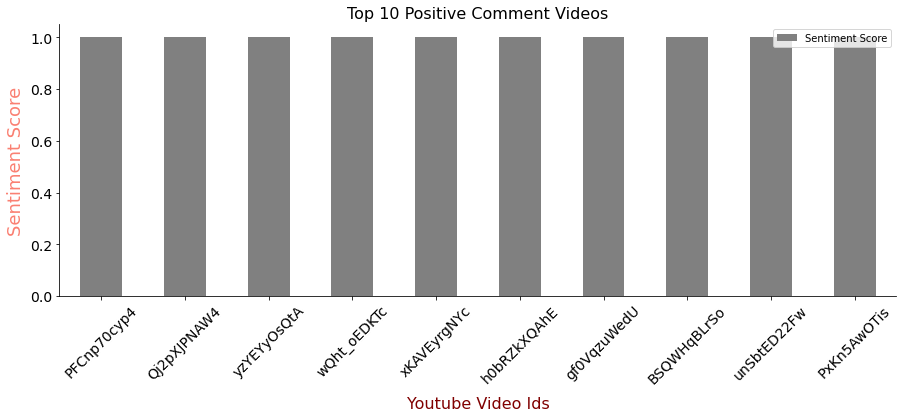

In [182]:
ax = top_10_positive.plot.bar(x='YoutubeId', y='Sentiment Score', rot=0, 
                 figsize=(15, 5), legend=True, fontsize=14, color ='grey')
ax.set_xticklabels(labels=top_10_positive['YoutubeId'],rotation=45)
ax.set_xlabel("Youtube Video Ids", fontsize=16, labelpad=10, color='maroon')
ax.set_ylabel("Sentiment Score", fontsize=18, labelpad=5, color='salmon')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.title("Top 10 Positive Comment Videos", fontsize=16)
plt.show()

In [183]:
labels = top_10_positive['Title'].values.tolist()
print('Top 10 highest sentiment scored videos:', labels)

Top 10 highest sentiment scored videos: ['How to Pickup Using the Theory of Relativity!', 'Passengers Trailer', 'Scaramouche (1952) Official Trailer - Stewart Granger, Janet Leigh Swashbuckler Movie HD', '"NEVER ON SUNDAY" TRAILER', "Man's favorite sport", 'Wild Child Trailer', 'Revolutionary Road, Leonardo DiCaprio and Kate Winslet together again!', "Constantine's Sword Trailer", 'WAR OF THE WORLDS 2: THE NEXT WAVE', '5 Centimeters Per Second Trailer']


<ipython-input-184-4b79f329eacb>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=top_10_positive['YoutubeId'],rotation=90, fontsize=16)


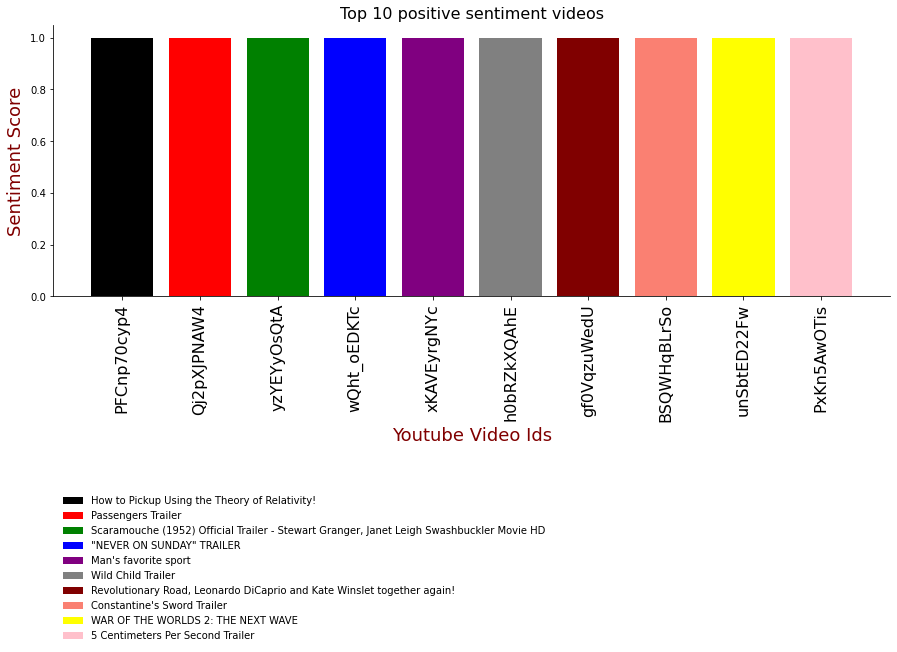

In [184]:
my_colors = ['black', 'red', 'green', 'blue', 'purple', 'grey', 'maroon', 'salmon', 'yellow','pink']

f = plt.figure(figsize =(15, 5) )


ax = plt.subplot(111) #specify a subplot

count = 0
for index, row in top_10_positive.iterrows():
    ax.bar(row['YoutubeId'], row['Sentiment Score'], color =my_colors[count], label = labels[count])
    count+=1
    
ax=plt.gca()

ax.set_xticklabels(labels=top_10_positive['YoutubeId'],rotation=90, fontsize=16)

ax.set_xlabel("Youtube Video Ids", fontsize=18, labelpad=5, color='maroon')
ax.set_ylabel("Sentiment Score", fontsize=18, labelpad=5, color='maroon')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.title("Top 10 positive sentiment videos", fontsize=16)

#plt.legend(labels,loc='best', frameon=False)#, bbox_to_anchor=(0.5, -0.5))
plt.legend(labels, loc="lower center",frameon=False, bbox_to_anchor=(0.3, -1.3))
plt.show()